# Analyzing Austin B-Cycle bicycle sharing program Data

This dataset contains trips and kiosk location data from the Austin B-Cycle bicycle sharing program.

# **Importing libraries**

In [0]:
!pip install wordcloud
!pip install nltk
import numpy as np
import pandas as pd 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
reviews = pd.read_csv('AustinB-Cycle_yelpreviews.csv')
reviews.head()

,title,user-location,review-content,rating-qualifier
0,Jon S.,"Cleveland, OH",Visitor here. Opted for the 24-hour explorer p...,2/4/2018
1,Mara R.,"Pittsburgh, PA","There's better, less expensive ways to get aro...",10/6/2018
2,Kyaw M.,"Allston, MA",TLDR: Please do yourself a favor and get one o...,12/27/2018
3,Kim K.,"Austin, TX",I understand the 24 hour pass/60 minute per ri...,3/31/2018
4,crystal g.,"Alice, TX",Worst bike share experience ever. We had famil...,7/9/2018


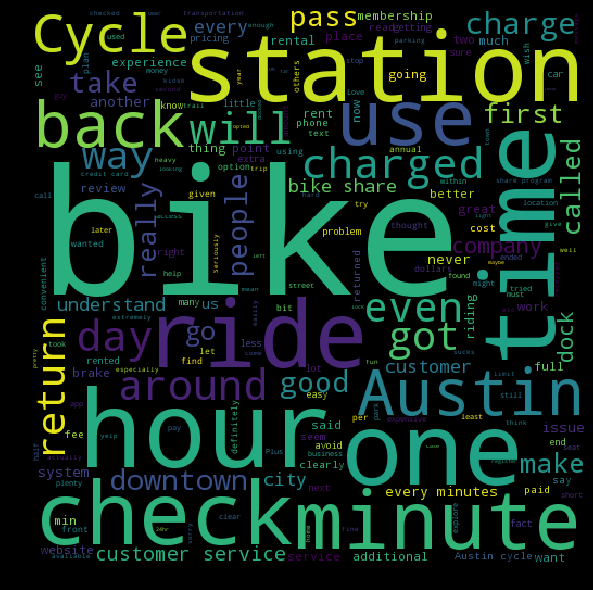

In [0]:
review_words = ' '.join(map(str,list(reviews['review-content'])))
reviews_wc = WordCloud(width = 512,height = 512).generate(review_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(reviews_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Loading the data: Trips and Kiosks Locations

In [0]:
ebikes = pd.read_csv('Austin_B-Cycle_Trips.csv')
ebikes.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10.0,2014.0
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,10/26/2014,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58,10.0,2014.0
2,9900285856,Annual Membership (Austin B-cycle),214.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8,10.0,2014.0
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,10/26/2014,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10.0,2014.0
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,10/26/2014,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10.0,2014.0


In [0]:
ebikes_locations = pd.read_csv('Austin_B-Cycle_Kiosk_Locations.csv')
ebikes_locations.head(8)

,Kiosk ID,Kiosk Name,Kiosk Status,Latitude,Longitude,Location
0,3291,11th & San Jacinto,active,30.27193,-97.73854,"(30.27193, -97.73854)"
1,3635,13th & San Antonio,active,30.27616,-97.74488,"(30.27616, -97.74488)"
2,2540,17th & Guadalupe,active,30.27974,-97.74254,"(30.27974, -97.74254)"
3,3798,21st & Speedway @PCL,active,30.28300,-97.73750,"(30.283, -97.7375)"
4,2564,5th & San Marcos,closed,30.26416,-97.73289,"(30.26416, -97.73289)"
5,3797,21st & University,active,30.28354,-97.73953,"(30.28354, -97.73953)"
6,1002,6th & Navasota St.,closed,30.26383,-97.72864,"(30.26383, -97.72864)"
7,3792,22nd & Pearl,active,30.28530,-97.74670,"(30.2853, -97.7467)"


In [0]:
ebikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077929 entries, 0 to 1077928
Data columns (total 12 columns):
Trip ID                  1077929 non-null int64
Membership Type          1071477 non-null object
Bicycle ID               1077206 non-null float64
Checkout Date            1077929 non-null object
Checkout Time            1077929 non-null object
Checkout Kiosk ID        1054775 non-null float64
Checkout Kiosk           1077929 non-null object
Return Kiosk ID          1053516 non-null float64
Return Kiosk             1077929 non-null object
Trip Duration Minutes    1077929 non-null int64
Month                    618479 non-null float64
Year                     618479 non-null float64
dtypes: float64(5), int64(2), object(5)
memory usage: 98.7+ MB


In [0]:
ebikes_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
Kiosk ID        94 non-null int64
Kiosk Name      94 non-null object
Kiosk Status    94 non-null object
Latitude        94 non-null float64
Longitude       94 non-null float64
Location        94 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 4.5+ KB


# Most Popular Checkout Kiosks

In [0]:
ebikes['Checkout Kiosk'].value_counts()

21st & Speedway @PCL                           60290
Riverside @ S. Lamar                           38082
City Hall / Lavaca & 2nd                       35259
2nd & Congress                                 34089
5th & Bowie                                    33123
Rainey St @ Cummings                           32549
4th & Congress                                 30637
Convention Center / 4th St. @ MetroRail        30456
Davis at Rainey Street                         30297
Capitol Station / Congress & 11th              25823
Pfluger Bridge @ W 2nd Street                  25442
UT West Mall @ Guadalupe                       24786
3rd & West                                     22251
Guadalupe & 21st                               21877
Dean Keeton & Speedway                         21167
Long Center @ South 1st & Riverside            21101
23rd & Rio Grande                              20535
Palmer Auditorium                              19945
Zilker Park                                   

In [0]:
Checkout_Kiosk = ['21st & Speedway @PCL','Riverside @ S. Lamar','City Hall / Lavaca & 2nd','2nd & Congress','5th & Bowie','Rainey St @ Cummings']

Checkout_Kiosks = dict((x,0) for x in Checkout_Kiosk)
for i in Checkout_Kiosk:
    x = ebikes['Checkout Kiosk'].str.contains(i).sum()
    if i in Checkout_Kiosk:
        Checkout_Kiosks[i] = x
        
print(Checkout_Kiosks)

{'21st & Speedway @PCL': 60290, 'Riverside @ S. Lamar': 38082, 'City Hall / Lavaca & 2nd': 35259, '2nd & Congress': 34089, '5th & Bowie': 33123, 'Rainey St @ Cummings': 32549}


In [0]:
Checkout_Kiosk_locations = sorted(Checkout_Kiosks.items(), key=lambda x: x[1], reverse=True)
Checkout_Kiosk = pd.DataFrame(Checkout_Kiosk_locations,columns=['Checkout_Kiosk','Count'])
Checkout_Kiosk['Count'] = Checkout_Kiosk.Count.astype('int')
Checkout_Kiosk

,Checkout_Kiosk,Count
0,21st & Speedway @PCL,60290
1,Riverside @ S. Lamar,38082
2,City Hall / Lavaca & 2nd,35259
3,2nd & Congress,34089
4,5th & Bowie,33123
5,Rainey St @ Cummings,32549


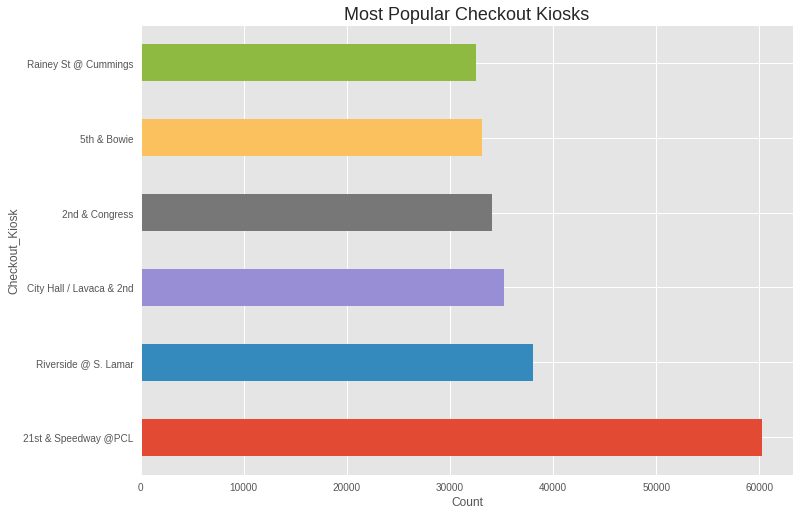

In [0]:
Checkout_Kiosk.plot.barh(x='Checkout_Kiosk',y='Count',legend=False)
plt.title('Most Popular Checkout Kiosks',fontsize=18)
plt.xlabel('Count')
plt.gcf().set_size_inches(11.7, 8.27)

# Most Popular Return Kiosks

In [0]:
ebikes['Return Kiosk'].value_counts()

21st & Speedway @PCL                           62042
City Hall / Lavaca & 2nd                       40617
2nd & Congress                                 37478
Riverside @ S. Lamar                           37089
4th & Congress                                 34288
Convention Center / 4th St. @ MetroRail        32990
Rainey St @ Cummings                           31722
5th & Bowie                                    31531
Davis at Rainey Street                         29915
Pfluger Bridge @ W 2nd Street                  24641
Dean Keeton & Speedway                         23296
UT West Mall @ Guadalupe                       22528
Capitol Station / Congress & 11th              22477
Guadalupe & 21st                               22078
Zilker Park                                    22004
Long Center @ South 1st & Riverside            21958
Barton Springs @ Kinney Ave                    21445
Convention Center / 3rd & Trinity              20028
3rd & West                                    

In [0]:
Return_Kiosk = ['21st & Speedway @PCL','City Hall / Lavaca & 2nd','2nd & Congress','Riverside @ S. Lamar','4th & Congress','Convention Center / 4th St. @ MetroRail']

Return_Kiosks = dict((x,0) for x in Return_Kiosk)
for i in Return_Kiosk:
    x = ebikes['Return Kiosk'].str.contains(i).sum()
    if i in Return_Kiosk:
        Return_Kiosks[i] = x
        
print(Return_Kiosks)

{'21st & Speedway @PCL': 62042, 'City Hall / Lavaca & 2nd': 40617, '2nd & Congress': 37478, 'Riverside @ S. Lamar': 37089, '4th & Congress': 34288, 'Convention Center / 4th St. @ MetroRail': 32990}


In [0]:
Return_Kiosk_locations = sorted(Return_Kiosks.items(), key=lambda x: x[1], reverse=True)
Return_Kiosk = pd.DataFrame(Return_Kiosk_locations,columns=['Return_Kiosk','Count'])
Return_Kiosk['Count'] = Return_Kiosk.Count.astype('int')
Return_Kiosk

,Return_Kiosk,Count
0,21st & Speedway @PCL,62042
1,City Hall / Lavaca & 2nd,40617
2,2nd & Congress,37478
3,Riverside @ S. Lamar,37089
4,4th & Congress,34288
5,Convention Center / 4th St. @ MetroRail,32990


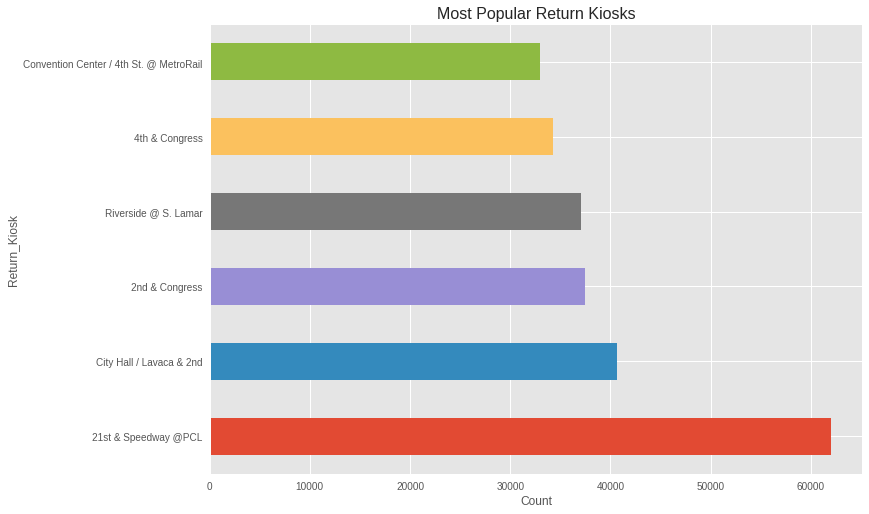

In [0]:
Return_Kiosk.plot.barh(x='Return_Kiosk',y='Count',legend=False)
plt.title('Most Popular Return Kiosks',fontsize=16)
plt.xlabel('Count')
plt.gcf().set_size_inches(11.7, 8.27)

# Most Popular Memberships Type

In [0]:
ebikes['Membership Type'].value_counts()

Walk Up                                          374151
U.T. Student Membership                          223405
Local365                                         173004
24-Hour Kiosk (Austin B-cycle)                   108672
Local30                                           56499
Weekender                                         45012
Annual Membership (Austin B-cycle)                30306
Explorer                                          15846
Local365+Guest Pass                               11447
Local365 ($80 plus tax)                            4005
Founding Member                                    3550
7-Day                                              3137
Founding Member (Austin B-cycle)                   2764
7-Day Membership (Austin B-cycle)                  2760
24 Hour Walk Up Pass                               2583
Semester Membership (Austin B-cycle)               2426
Annual                                             1157
3-Day Weekender                                 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


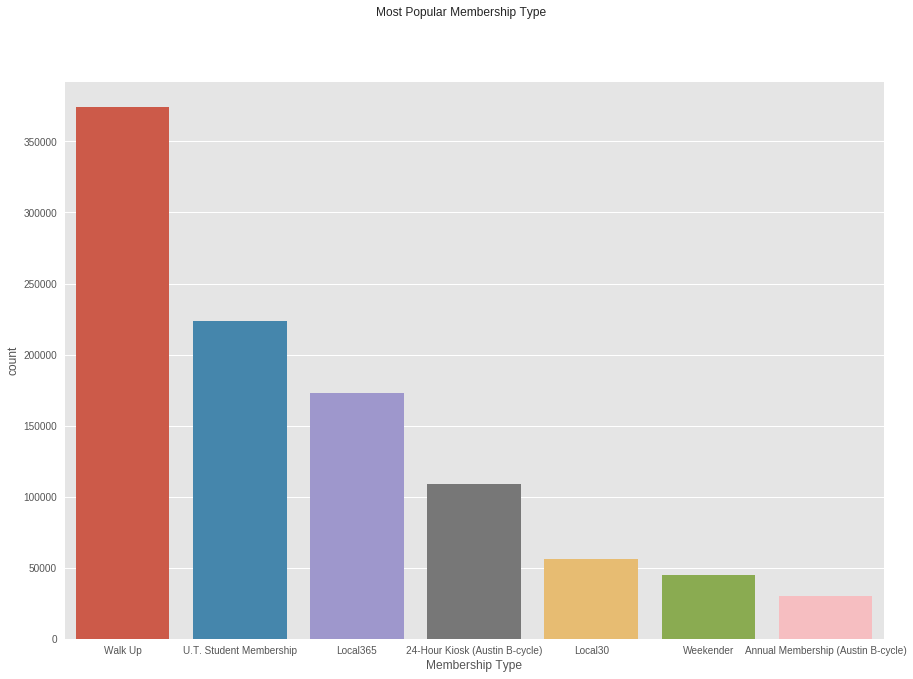

In [0]:
import seaborn as sns
sns.countplot('Membership Type', data=ebikes, order=pd.value_counts(ebikes['Membership Type']).iloc[:7].index)
plt.suptitle('Most Popular Membership Type')
plt.gcf().set_size_inches(14.7, 10.27)

# Dates with most activity

In [0]:
ebikes['Checkout Date'].value_counts()

03/19/2015    3031
03/24/2018    2862
03/10/2018    2842
03/14/2014    2808
03/30/2018    2762
03/02/2018    2740
03/14/2015    2738
03/06/2018    2733
03/17/2018    2705
02/28/2018    2659
03/05/2018    2659
03/15/2015    2652
04/19/2018    2618
04/27/2018    2615
03/16/2018    2606
03/01/2018    2591
03/23/2018    2589
03/15/2014    2587
03/08/2018    2574
03/09/2018    2569
03/07/2018    2527
03/22/2018    2513
03/26/2018    2496
04/20/2018    2483
04/18/2018    2482
05/03/2018    2477
03/18/2015    2471
03/31/2018    2469
03/29/2018    2457
03/04/2018    2451
              ... 
02/05/2014      62
10/24/2015      55
02/10/2014      53
01/29/2014      53
02/03/2014      53
02/26/2014      52
12/27/2015      52
12/06/2017      52
02/23/2015      49
01/07/2014      48
01/02/2015      47
11/05/2014      46
11/22/2014      46
01/22/2015      45
11/28/2015      45
01/05/2014      44
02/28/2015      41
02/06/2014      41
01/01/2015      36
02/11/2014      33
01/24/2014      31
01/08/2014  

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


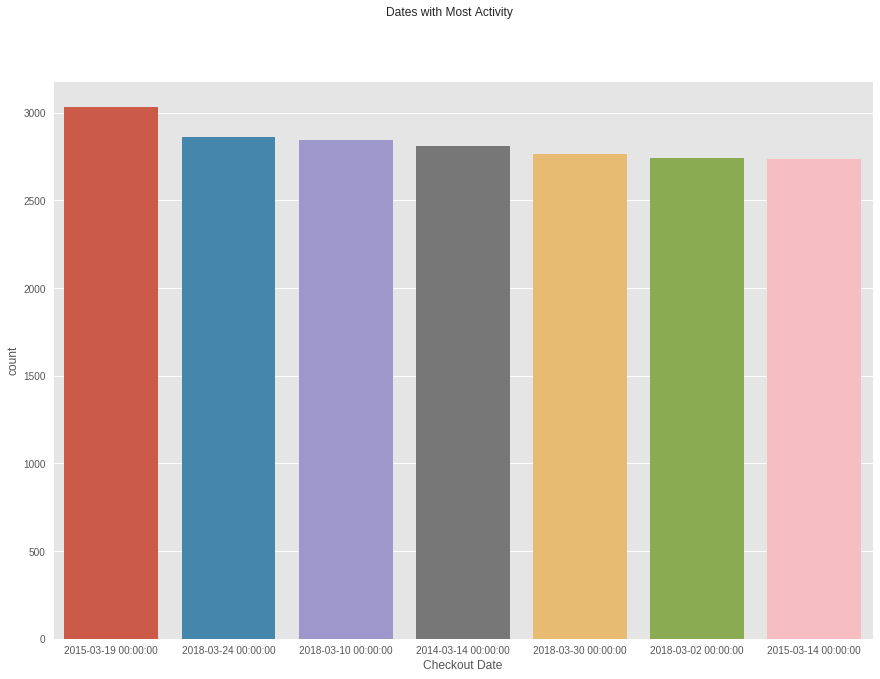

In [0]:
import seaborn as sns
sns.countplot('Checkout Date', data=ebikes, order=pd.value_counts(ebikes['Checkout Date']).iloc[:7].index)
plt.suptitle('Dates with Most Activity')
plt.gcf().set_size_inches(14.7, 10.27)

# Kiosk Locations in a heatmap

In [0]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
ebikes_locations.head()

,Kiosk ID,Kiosk Name,Kiosk Status,Latitude,Longitude,Location
0,3291,11th & San Jacinto,active,30.27193,-97.73854,"(30.27193, -97.73854)"
1,3635,13th & San Antonio,active,30.27616,-97.74488,"(30.27616, -97.74488)"
2,2540,17th & Guadalupe,active,30.27974,-97.74254,"(30.27974, -97.74254)"
3,3798,21st & Speedway @PCL,active,30.28300,-97.73750,"(30.283, -97.7375)"
4,2564,5th & San Marcos,closed,30.26416,-97.73289,"(30.26416, -97.73289)"


In [0]:
m = folium.Map([30.27193, -97.73854], zoom_start=13)
m

In [0]:
# mark each station as a point
for index, row in ebikes_locations.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=15,
                        popup=row['Kiosk Name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

In [0]:
# convert to (n, 2) nd-array format for heatmap
stationArr = ebikes_locations[['Latitude', 'Longitude']].as_matrix()

# plot heatmap
m.add_children(plugins.HeatMap(stationArr, radius=15))
m

In [0]:
ebikes.describe()

,Trip ID,Bicycle ID,Checkout Kiosk ID,Return Kiosk ID,Trip Duration Minutes,Month,Year
count,1.077929e+06,1.077206e+06,1.054775e+06,1.053516e+06,1.077929e+06,618479.000000,618479.000000
mean,3.250189e+09,6.399591e+02,2.845409e+03,2.843819e+03,2.721814e+01,5.887185,2015.340026
std,4.638169e+09,8.042368e+02,5.571200e+02,5.565237e+02,8.700783e+01,3.206358,1.019771
min,8.269930e+06,3.000000e+00,1.001000e+03,1.001000e+03,0.000000e+00,1.000000,2013.000000
25%,1.505886e+07,2.260000e+02,2.504000e+03,2.503000e+03,6.000000e+00,3.000000,2014.000000
50%,1.719355e+07,4.590000e+02,2.565000e+03,2.565000e+03,1.200000e+01,5.000000,2015.000000
75%,9.900083e+09,8.620000e+02,3.377000e+03,3.377000e+03,2.600000e+01,9.000000,2016.000000
max,9.900353e+09,1.426400e+04,4.062000e+03,4.062000e+03,2.129600e+04,12.000000,2017.000000


In [0]:
ebikes_locations.describe()

,Kiosk ID,Latitude,Longitude
count,94.000000,94.000000,94.000000
mean,2930.074468,30.268709,-97.742647
std,833.828471,0.010483,0.014049
min,1001.000000,30.242580,-97.783750
25%,2540.250000,30.262778,-97.749125
50%,2574.500000,30.267535,-97.742715
75%,3685.750000,30.274335,-97.737000
max,4062.000000,30.294390,-97.710020


In [0]:
ebikes['Trip Duration Minutes'].describe()

count    1.077929e+06
mean     2.721814e+01
std      8.700783e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.200000e+01
75%      2.600000e+01
max      2.129600e+04
Name: Trip Duration Minutes, dtype: float64

# Kiosks Status

In [0]:
ebikes_locations['Kiosk Status'].value_counts()

active    75
closed    19
Name: Kiosk Status, dtype: int64

In [0]:
Kiosk_Status = ['active','closed']

Kiosks_Status = dict((x,0) for x in Kiosk_Status)
for i in Kiosk_Status:
    x = ebikes_locations['Kiosk Status'].str.contains(i).sum()
    if i in Kiosks_Status:
        Kiosks_Status[i] = x
        
print(Kiosks_Status)

{'active': 75, 'closed': 19}


In [0]:
Kiosk_Status = sorted(Kiosks_Status.items(), key=lambda x: x[1], reverse=True)
Kiosk_Status = pd.DataFrame(Kiosk_Status,columns=['Kiosk_Status','Count'])
Kiosk_Status['Count'] = Kiosk_Status.Count.astype('int')
Kiosk_Status

,Kiosk_Status,Count
0,active,75
1,closed,19


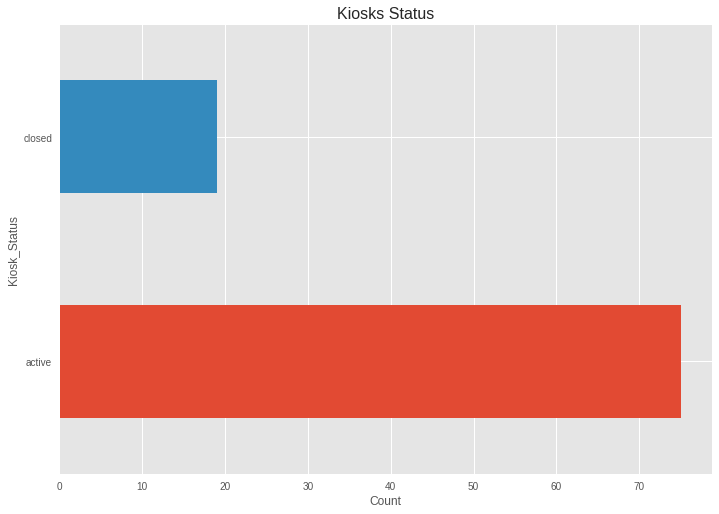

In [0]:
Kiosk_Status.plot.barh(x='Kiosk_Status',y='Count',legend=False)
plt.title('Kiosks Status',fontsize=16)
plt.xlabel('Count')
plt.gcf().set_size_inches(11.7, 8.27)

# Active Kiosks in the heatmap

In [0]:
Active_Kiosks= ebikes_locations[ebikes_locations['Kiosk Status'].notnull() & (ebikes_locations['Kiosk Status'] == 'active')]

In [0]:
Active_Kiosks.head(75)

,Kiosk ID,Kiosk Name,Kiosk Status,Latitude,Longitude,Location
0,3291,11th & San Jacinto,active,30.27193,-97.73854,"(30.27193, -97.73854)"
1,3635,13th & San Antonio,active,30.27616,-97.74488,"(30.27616, -97.74488)"
2,2540,17th & Guadalupe,active,30.27974,-97.74254,"(30.27974, -97.74254)"
3,3798,21st & Speedway @PCL,active,30.28300,-97.73750,"(30.283, -97.7375)"
5,3797,21st & University,active,30.28354,-97.73953,"(30.28354, -97.73953)"
7,3792,22nd & Pearl,active,30.28530,-97.74670,"(30.2853, -97.7467)"
11,3841,23rd & Rio Grande,active,30.28728,-97.74495,"(30.28728, -97.74495)"
12,3799,23rd & San Jacinto @ DKR Stadium,active,30.28560,-97.73350,"(30.2856, -97.7335)"
13,2494,2nd & Congress,active,30.26408,-97.74355,"(30.26408, -97.74355)"
15,2552,3rd & West,active,30.26780,-97.75189,"(30.2678, -97.75189)"


In [0]:
Active_Kiosks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 93
Data columns (total 6 columns):
Kiosk ID        75 non-null int64
Kiosk Name      75 non-null object
Kiosk Status    75 non-null object
Latitude        75 non-null float64
Longitude       75 non-null float64
Location        75 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 4.1+ KB


In [0]:
active_status = folium.Map([30.27193, -97.73854], zoom_start=16)
active_status

In [0]:
# mark each station as a point
for index, row in Active_Kiosks.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=15,
                        popup=row['Kiosk Name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(active_status)

In [0]:
# convert to (n, 2) nd-array format for heatmap
activeArr = Active_Kiosks[['Latitude', 'Longitude']].as_matrix()

# plot heatmap
active_status.add_children(plugins.HeatMap(stationArr, radius=15))
active_status

# Closed Kioks in the heatmap

In [0]:
Closed_Kiosks= ebikes_locations[ebikes_locations['Kiosk Status'].notnull() & (ebikes_locations['Kiosk Status'] == 'closed')]

In [0]:
Closed_Kiosks.head()
Closed_Kiosks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 4 to 71
Data columns (total 6 columns):
Kiosk ID        19 non-null int64
Kiosk Name      19 non-null object
Kiosk Status    19 non-null object
Latitude        19 non-null float64
Longitude       19 non-null float64
Location        19 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ KB


In [0]:
Closed_Kiosks.head(19)

,Kiosk ID,Kiosk Name,Kiosk Status,Latitude,Longitude,Location
4,2564,5th & San Marcos,closed,30.26416,-97.73289,"(30.26416, -97.73289)"
6,1002,6th & Navasota St.,closed,30.26383,-97.72864,"(30.26383, -97.72864)"
8,1003,8th & Guadalupe,closed,30.27106,-97.74563,"(30.27106, -97.74563)"
9,2545,ACC - Rio Grande & 12th,closed,30.27595,-97.74739,"(30.27595, -97.74739)"
10,2546,ACC - West & 12th Street,closed,30.27624,-97.74831,"(30.27624, -97.74831)"
14,2538,Bullock Museum @ Congress & MLK,closed,30.28039,-97.73809,"(30.28039, -97.73809)"
27,3381,East 7th & Pleasant Valley,closed,30.26025,-97.71002,"(30.26025, -97.71002)"
31,1007,Lavaca & 6th,closed,30.26889,-97.74525,"(30.26889, -97.74525)"
37,1008,Nueces @ 3rd,closed,30.26694,-97.74939,"(30.26694, -97.74939)"
41,3464,Pease Park,closed,30.28118,-97.75219,"(30.28118, -97.75219)"


In [0]:
closed_status = folium.Map([30.27193, -97.73854], zoom_start=16)
closed_status

In [0]:
# mark each station as a point
for index, row in Closed_Kiosks.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=15,
                        popup=row['Kiosk Name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(closed_status)

In [0]:
# convert to (n, 2) nd-array format for heatmap
closedArr = Closed_Kiosks[['Latitude', 'Longitude']].as_matrix()

# plot heatmap
closed_status.add_children(plugins.HeatMap(stationArr, radius=15))
closed_status

# Months with most activity

In [0]:
ebikes['Month'].value_counts()

3.0     112002
10.0     69925
5.0      69572
4.0      53419
7.0      46933
6.0      44084
1.0      43761
9.0      42746
2.0      42032
8.0      38036
11.0     37182
12.0     18787
Name: Month, dtype: int64

Text(0, 0.5, 'Month')

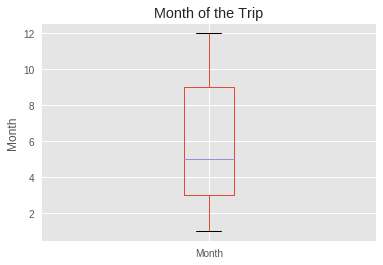

In [0]:
ebikes.Month.plot(kind='box')
plt.title('Month of the Trip')
plt.ylabel('Month')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


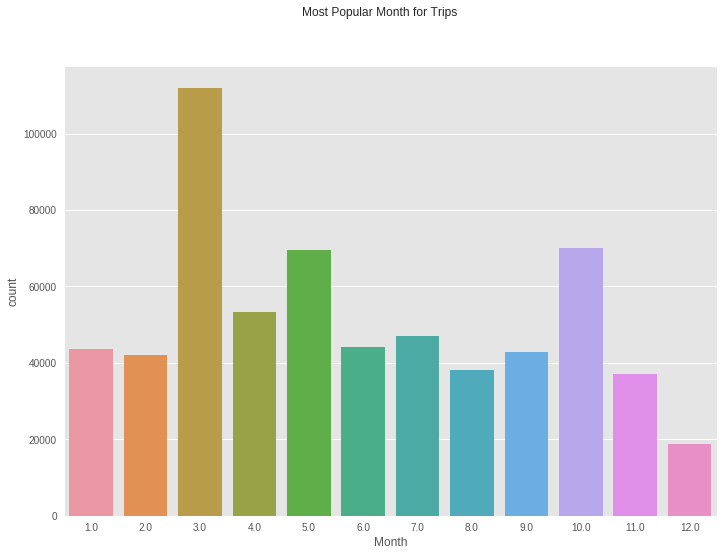

In [0]:
import seaborn as sns
sns.countplot('Month',data=ebikes)
plt.suptitle('Most Popular Month for Trips')
plt.gcf().set_size_inches(11.7, 8.27)

As you can see, March and October are the months with most activiy. The reason could be that SXSW event it's every year on March and Austin City Limits occurs every year  between September and October, we can infer that people decide to go on the second weekend.

In [0]:
checkout_return_kiosks= ebikes[['Checkout Kiosk','Return Kiosk', 'Trip Duration Minutes']]

In [0]:
checkout_return_kiosks.head(40)

,Checkout Kiosk,Return Kiosk,Trip Duration Minutes
0,West & 6th St.,Rainey St @ Cummings,76
1,Convention Center / 4th St. @ MetroRail,Pfluger Bridge @ W 2nd Street,58
2,West & 6th St.,8th & Congress,8
3,Zilker Park at Barton Springs & William Barton...,Zilker Park at Barton Springs & William Barton...,28
4,Bullock Museum @ Congress & MLK,Convention Center/ 3rd & Trinity,15
5,Zilker Park at Barton Springs & William Barton...,ACC - Rio Grande & 12th,26
6,8th & Congress,State Capitol Visitors Garage @ San Jacinto & ...,35
7,East 11th St. & San Marcos,City Hall / Lavaca & 2nd,11
8,8th & Congress,8th & Congress,0
9,Zilker Park at Barton Springs & William Barton...,ACC - Rio Grande & 12th,25


# Trips with duration less than 2 Minutes

In [0]:
Small_Trips= ebikes[ebikes['Checkout Kiosk'].notnull() & (ebikes['Trip Duration Minutes'] < 2)]

In [0]:
Small_Trips.head(20)

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
8,9900285862,Annual Membership (Austin B-cycle),517.0,10/26/2014,13:12:00,2496.0,8th & Congress,2496.0,8th & Congress,0,10.0,2014.0
63,9900285917,Annual Membership (Austin B-cycle),202.0,10/26/2014,14:12:00,2503.0,South Congress & James,2503.0,South Congress & James,0,10.0,2014.0
144,9900285998,24-Hour Kiosk (Austin B-cycle),206.0,10/26/2014,15:12:00,2502.0,Barton Springs & Riverside,2502.0,Barton Springs & Riverside,0,10.0,2014.0
147,9900286001,24-Hour Kiosk (Austin B-cycle),572.0,10/26/2014,15:12:00,2563.0,Davis at Rainey Street,2563.0,Davis at Rainey Street,0,10.0,2014.0
163,9900286017,24-Hour Kiosk (Austin B-cycle),503.0,10/26/2014,16:12:00,2499.0,City Hall / Lavaca & 2nd,2499.0,City Hall / Lavaca & 2nd,0,10.0,2014.0
199,9900286051,24-Hour Kiosk (Austin B-cycle),801.0,10/26/2014,16:12:00,2503.0,South Congress & James,2495.0,4th & Congress,0,10.0,2014.0
230,9900286082,7-Day Membership (Austin B-cycle),185.0,10/26/2014,17:12:00,2549.0,Long Center @ South 1st & Riverside,2549.0,Long Center @ South 1st & Riverside,1,10.0,2014.0
308,9900286158,24-Hour Kiosk (Austin B-cycle),75.0,10/26/2014,18:12:00,2549.0,Long Center @ South 1st & Riverside,2549.0,Long Center @ South 1st & Riverside,0,10.0,2014.0
332,9900286182,24-Hour Kiosk (Austin B-cycle),135.0,10/26/2014,19:12:00,2547.0,Guadalupe & 21st,2547.0,Guadalupe & 21st,0,10.0,2014.0
337,9900286187,24-Hour Kiosk (Austin B-cycle),882.0,10/26/2014,19:12:00,2494.0,2nd & Congress,2494.0,2nd & Congress,1,10.0,2014.0


# Days when these small trips were done

In [0]:
Small_Trips['Checkout Date'].value_counts()

03/01/2018    348
02/28/2018    303
03/02/2018    260
02/27/2018    252
03/17/2018    227
03/03/2018    167
03/04/2018    162
04/19/2018    161
03/06/2018    157
03/05/2018    155
03/25/2018    148
04/01/2018    147
03/24/2018    147
03/16/2018    146
04/23/2018    145
02/26/2018    141
03/14/2014    141
03/09/2018    136
03/10/2018    136
03/20/2018    134
05/06/2018    132
03/13/2014    131
03/15/2018    129
03/14/2018    129
03/19/2018    128
03/31/2018    128
03/29/2018    125
03/26/2018    125
04/18/2018    122
04/22/2018    121
             ... 
01/11/2015      2
12/28/2013      2
01/24/2014      2
02/06/2014      2
01/22/2014      2
03/04/2017      2
01/07/2015      2
01/22/2015      2
08/15/2016      2
01/06/2017      2
02/05/2015      2
01/02/2015      2
12/28/2014      2
12/07/2017      2
02/03/2015      1
01/12/2015      1
02/27/2015      1
01/21/2014      1
02/03/2017      1
12/30/2013      1
08/16/2016      1
11/29/2015      1
11/15/2014      1
12/22/2017      1
01/13/2014

In [0]:
Small_Trips.describe()

,Trip ID,Bicycle ID,Checkout Kiosk ID,Return Kiosk ID,Trip Duration Minutes,Month,Year
count,3.978000e+04,39720.000000,39114.000000,39100.000000,39780.000000,19280.000000,19280.000000
mean,2.999454e+09,717.313293,2932.238994,2920.687673,0.491327,6.153371,2015.269554
std,4.537666e+09,848.983051,608.922740,652.965582,0.499931,3.237343,0.989496
min,8.271012e+06,3.000000,1002.000000,1002.000000,0.000000,1.000000,2013.000000
25%,1.632770e+07,235.000000,2537.000000,2537.000000,0.000000,3.000000,2014.000000
50%,1.713810e+07,514.000000,2567.000000,2567.000000,0.000000,6.000000,2015.000000
75%,9.900060e+09,875.000000,3687.000000,3790.000000,1.000000,9.000000,2016.000000
max,9.900353e+09,14264.000000,4062.000000,4062.000000,1.000000,12.000000,2017.000000


# Small Trips where Checkot and Return Kioks are the same

In [0]:
Small_Trips_Same= ebikes[ebikes['Checkout Kiosk'].notnull() & (ebikes['Trip Duration Minutes'] < 2) & (ebikes['Checkout Kiosk'] == ebikes['Return Kiosk'])]

In [0]:
Small_Trips_Same.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35032 entries, 8 to 1077923
Data columns (total 12 columns):
Trip ID                  35032 non-null int64
Membership Type          33688 non-null object
Bicycle ID               34974 non-null float64
Checkout Date            35032 non-null object
Checkout Time            35032 non-null object
Checkout Kiosk ID        34464 non-null float64
Checkout Kiosk           35032 non-null object
Return Kiosk ID          34464 non-null float64
Return Kiosk             35032 non-null object
Trip Duration Minutes    35032 non-null int64
Month                    16020 non-null float64
Year                     16020 non-null float64
dtypes: float64(5), int64(2), object(5)
memory usage: 4.7+ MB


In [0]:
Small_Trips_Same.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
8,9900285862,Annual Membership (Austin B-cycle),517.0,10/26/2014,13:12:00,2496.0,8th & Congress,2496.0,8th & Congress,0,10.0,2014.0
63,9900285917,Annual Membership (Austin B-cycle),202.0,10/26/2014,14:12:00,2503.0,South Congress & James,2503.0,South Congress & James,0,10.0,2014.0
144,9900285998,24-Hour Kiosk (Austin B-cycle),206.0,10/26/2014,15:12:00,2502.0,Barton Springs & Riverside,2502.0,Barton Springs & Riverside,0,10.0,2014.0
147,9900286001,24-Hour Kiosk (Austin B-cycle),572.0,10/26/2014,15:12:00,2563.0,Davis at Rainey Street,2563.0,Davis at Rainey Street,0,10.0,2014.0
163,9900286017,24-Hour Kiosk (Austin B-cycle),503.0,10/26/2014,16:12:00,2499.0,City Hall / Lavaca & 2nd,2499.0,City Hall / Lavaca & 2nd,0,10.0,2014.0


In [0]:
Small_Trips_Same['Membership Type'].value_counts()

U.T. Student Membership                          10212
Walk Up                                           9890
Local365                                          4893
24-Hour Kiosk (Austin B-cycle)                    2687
Local30                                           1698
Weekender                                         1277
Annual Membership (Austin B-cycle)                 974
Explorer                                           483
Local365+Guest Pass                                338
RideScout Single Ride                              277
Founding Member                                     91
Local365 ($80 plus tax)                             90
Founding Member (Austin B-cycle)                    87
7-Day Membership (Austin B-cycle)                   82
Annual                                              70
Semester Membership (Austin B-cycle)                61
7-Day                                               57
24 Hour Walk Up Pass                                45
Annual (Sa

In [0]:
Small_Trips['Checkout Date'].value_counts()

03/01/2018    348
02/28/2018    303
03/02/2018    260
02/27/2018    252
03/17/2018    227
03/03/2018    167
03/04/2018    162
04/19/2018    161
03/06/2018    157
03/05/2018    155
03/25/2018    148
04/01/2018    147
03/24/2018    147
03/16/2018    146
04/23/2018    145
02/26/2018    141
03/14/2014    141
03/09/2018    136
03/10/2018    136
03/20/2018    134
05/06/2018    132
03/13/2014    131
03/15/2018    129
03/14/2018    129
03/19/2018    128
03/31/2018    128
03/29/2018    125
03/26/2018    125
04/18/2018    122
04/22/2018    121
             ... 
01/11/2015      2
12/28/2013      2
01/24/2014      2
02/06/2014      2
01/22/2014      2
03/04/2017      2
01/07/2015      2
01/22/2015      2
08/15/2016      2
01/06/2017      2
02/05/2015      2
01/02/2015      2
12/28/2014      2
12/07/2017      2
02/03/2015      1
01/12/2015      1
02/27/2015      1
01/21/2014      1
02/03/2017      1
12/30/2013      1
08/16/2016      1
11/29/2015      1
11/15/2014      1
12/22/2017      1
01/13/2014

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


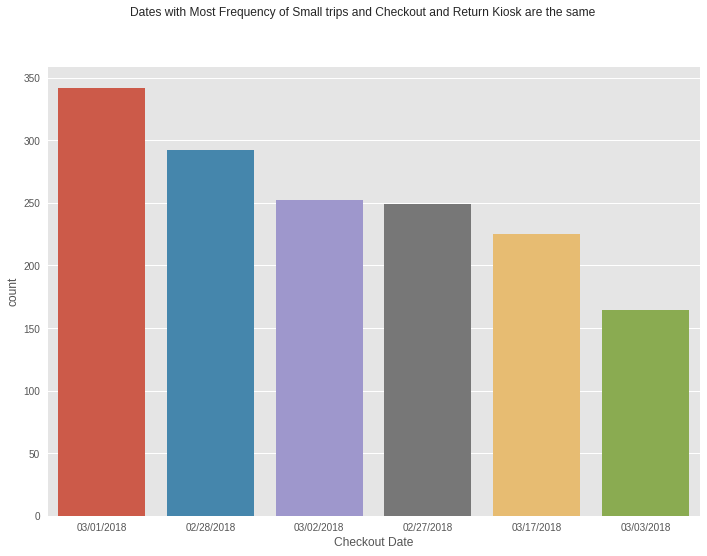

In [0]:
import seaborn as sns
sns.countplot('Checkout Date', data=Small_Trips_Same, order=pd.value_counts(Small_Trips_Same['Checkout Date']).iloc[:6].index)
plt.suptitle('Dates with Most Frequency of Small trips and Checkout and Return Kiosk are the same')
plt.gcf().set_size_inches(11.7, 8.27)

I'm thinking that maybe on 03/02/2019, the system was not working

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


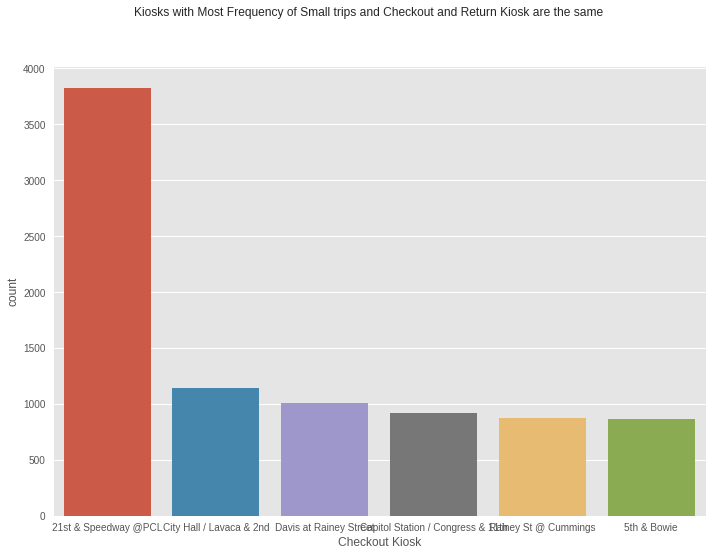

In [0]:
import seaborn as sns
sns.countplot('Checkout Kiosk', data=Small_Trips_Same, order=pd.value_counts(Small_Trips_Same['Checkout Kiosk']).iloc[:6].index)
plt.suptitle('Kiosks with Most Frequency of Small trips and Checkout and Return Kiosk are the same')
plt.gcf().set_size_inches(11.7, 8.27)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


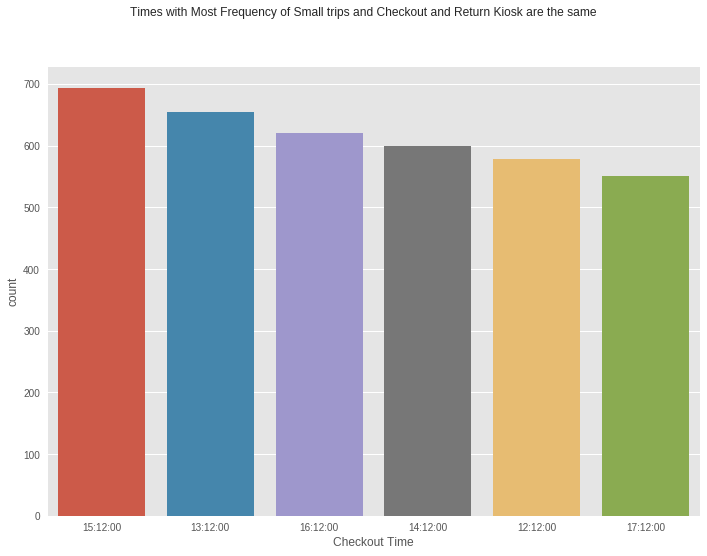

In [0]:
import seaborn as sns
sns.countplot('Checkout Time', data=Small_Trips_Same, order=pd.value_counts(Small_Trips_Same['Checkout Time']).iloc[:6].index)
plt.suptitle('Times with Most Frequency of Small trips and Checkout and Return Kiosk are the same')
plt.gcf().set_size_inches(11.7, 8.27)

It seem that the Kiosk clos to the UT had this problem.

# Large Trips

In [0]:
Large_Trips= ebikes[ebikes['Checkout Kiosk'].notnull() & (ebikes['Trip Duration Minutes'] > 60)]

In [0]:
Large_Trips.head(15)

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10.0,2014.0
29,9900285883,24-Hour Kiosk (Austin B-cycle),545.0,10/26/2014,14:12:00,2575.0,Riverside @ S. Lamar,2575.0,Riverside @ S. Lamar,96,10.0,2014.0
30,9900285884,24-Hour Kiosk (Austin B-cycle),240.0,10/26/2014,14:12:00,2567.0,Palmer Auditorium,2499.0,City Hall / Lavaca & 2nd,126,10.0,2014.0
31,9900285885,24-Hour Kiosk (Austin B-cycle),897.0,10/26/2014,14:12:00,2494.0,2nd & Congress,2566.0,Pfluger Bridge @ W 2nd Street,61,10.0,2014.0
74,9900285928,24-Hour Kiosk (Austin B-cycle),540.0,10/26/2014,14:12:00,2566.0,Pfluger Bridge @ W 2nd Street,2566.0,Pfluger Bridge @ W 2nd Street,85,10.0,2014.0
83,9900285937,24-Hour Kiosk (Austin B-cycle),432.0,10/26/2014,14:12:00,2495.0,4th & Congress,2495.0,4th & Congress,100,10.0,2014.0
84,9900285938,24-Hour Kiosk (Austin B-cycle),229.0,10/26/2014,14:12:00,2495.0,4th & Congress,2495.0,4th & Congress,100,10.0,2014.0
86,9900285940,24-Hour Kiosk (Austin B-cycle),276.0,10/26/2014,14:12:00,2495.0,4th & Congress,2495.0,4th & Congress,99,10.0,2014.0
87,9900285941,24-Hour Kiosk (Austin B-cycle),919.0,10/26/2014,15:12:00,2567.0,Palmer Auditorium,2563.0,Davis at Rainey Street,87,10.0,2014.0
88,9900285942,24-Hour Kiosk (Austin B-cycle),64.0,10/26/2014,15:12:00,2570.0,South Congress & Academy,2504.0,South Congress & Elizabeth,199,10.0,2014.0


# Large Trips where Checkout and Return kiosk are the same

In [0]:
Large_Trips_Same_Kiosk= Large_Trips[Large_Trips['Checkout Kiosk'].notnull() & (Large_Trips['Checkout Kiosk'] == Large_Trips['Return Kiosk'])]

In [0]:
Large_Trips_Same_Kiosk.head(10)

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
29,9900285883,24-Hour Kiosk (Austin B-cycle),545.0,10/26/2014,14:12:00,2575.0,Riverside @ S. Lamar,2575.0,Riverside @ S. Lamar,96,10.0,2014.0
74,9900285928,24-Hour Kiosk (Austin B-cycle),540.0,10/26/2014,14:12:00,2566.0,Pfluger Bridge @ W 2nd Street,2566.0,Pfluger Bridge @ W 2nd Street,85,10.0,2014.0
83,9900285937,24-Hour Kiosk (Austin B-cycle),432.0,10/26/2014,14:12:00,2495.0,4th & Congress,2495.0,4th & Congress,100,10.0,2014.0
84,9900285938,24-Hour Kiosk (Austin B-cycle),229.0,10/26/2014,14:12:00,2495.0,4th & Congress,2495.0,4th & Congress,100,10.0,2014.0
86,9900285940,24-Hour Kiosk (Austin B-cycle),276.0,10/26/2014,14:12:00,2495.0,4th & Congress,2495.0,4th & Congress,99,10.0,2014.0
92,9900285946,24-Hour Kiosk (Austin B-cycle),416.0,10/26/2014,15:12:00,2502.0,Barton Springs & Riverside,2502.0,Barton Springs & Riverside,76,10.0,2014.0
93,9900285947,24-Hour Kiosk (Austin B-cycle),362.0,10/26/2014,15:12:00,2502.0,Barton Springs & Riverside,2502.0,Barton Springs & Riverside,76,10.0,2014.0
103,9900285957,24-Hour Kiosk (Austin B-cycle),80.0,10/26/2014,15:12:00,2565.0,Trinity & 6th Street,2565.0,Trinity & 6th Street,252,10.0,2014.0
117,9900285971,24-Hour Kiosk (Austin B-cycle),60.0,10/26/2014,15:12:00,2575.0,Riverside @ S. Lamar,2575.0,Riverside @ S. Lamar,98,10.0,2014.0
119,9900285973,24-Hour Kiosk (Austin B-cycle),62.0,10/26/2014,15:12:00,2575.0,Riverside @ S. Lamar,2575.0,Riverside @ S. Lamar,95,10.0,2014.0


When trips are larger than 60 Minutes an the checkout and return kiosk are the same, it may be users that park somwhere close to the kiosk and rent a bike to exercise

In [0]:
Morning_Trips= ebikes[ebikes['Checkout Kiosk'].notnull() & (ebikes['Checkout Time'] < '12:00:00')]

In [0]:
Morning_Trips.head(20)

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
181,14713922,Walk Up,663.0,05/07/2017,11:48:43,3619.0,6th & Congress,2574.0,Zilker Park,38,5.0,2017.0
401,9900286251,7-Day Membership (Austin B-cycle),970.0,10/27/2014,0:12:00,2495.0,4th & Congress,2707.0,Rainey St @ Cummings,7,10.0,2014.0
453,9900286303,Annual Membership (Austin B-cycle),396.0,10/27/2014,10:12:00,2542.0,Plaza Saltillo,2564.0,5th & San Marcos,4,10.0,2014.0
454,9900286304,Annual Membership (Austin B-cycle),55.0,10/27/2014,10:12:00,2822.0,East 6th at Robert Martinez,2495.0,4th & Congress,12,10.0,2014.0
455,9900286305,24-Hour Kiosk (Austin B-cycle),72.0,10/27/2014,10:12:00,2548.0,UT West Mall @ Guadalupe,2497.0,Capitol Station / Congress & 11th,10,10.0,2014.0
456,9900286306,24-Hour Kiosk (Austin B-cycle),117.0,10/27/2014,10:12:00,2569.0,East 11th St. & San Marcos,2542.0,Plaza Saltillo,13,10.0,2014.0
457,9900286307,24-Hour Kiosk (Austin B-cycle),367.0,10/27/2014,10:12:00,2569.0,East 11th St. & San Marcos,2542.0,Plaza Saltillo,13,10.0,2014.0
458,9900286308,7-Day Membership (Austin B-cycle),232.0,10/27/2014,10:12:00,2496.0,8th & Congress,2496.0,8th & Congress,1,10.0,2014.0
459,9900286309,24-Hour Kiosk (Austin B-cycle),540.0,10/27/2014,10:12:00,2504.0,South Congress & Elizabeth,2538.0,Bullock Museum @ Congress & MLK,19,10.0,2014.0
460,9900286310,24-Hour Kiosk (Austin B-cycle),958.0,10/27/2014,10:12:00,2504.0,South Congress & Elizabeth,2538.0,Bullock Museum @ Congress & MLK,18,10.0,2014.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


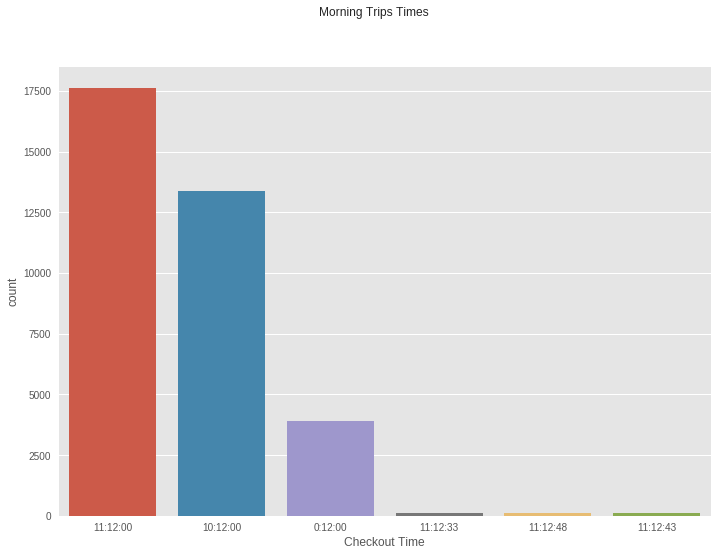

In [0]:
import seaborn as sns
sns.countplot('Checkout Time', data=Morning_Trips, order=pd.value_counts(Morning_Trips['Checkout Time']).iloc[:6].index)
plt.suptitle('Morning Trips Times')
plt.gcf().set_size_inches(11.7, 8.27)

In [0]:
Afternoon_Trips= ebikes[ebikes['Checkout Kiosk'].notnull() & (ebikes['Checkout Time'] > '12:00:00')]

In [0]:
Afternoon_Trips.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10.0,2014.0
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,10/26/2014,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58,10.0,2014.0
2,9900285856,Annual Membership (Austin B-cycle),214.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8,10.0,2014.0
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,10/26/2014,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10.0,2014.0
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,10/26/2014,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10.0,2014.0


In [0]:
Morning_Trips['Checkout Time'].value_counts()

11:12:00    17632
10:12:00    13361
0:12:00      3920
11:12:33      113
11:12:48      111
11:12:43      108
11:12:02      108
11:12:32      106
11:12:19      106
11:12:41      104
11:12:09      104
11:12:03      103
11:12:16      101
11:12:58      101
11:12:21      100
11:12:12      100
11:12:35       99
11:12:38       98
11:12:01       97
11:12:30       97
11:12:36       97
11:12:10       97
11:12:23       97
11:12:45       96
11:12:39       96
11:12:28       96
11:12:51       96
11:12:52       95
11:12:22       95
11:12:26       95
            ...  
0:18:10         1
0:53:47         1
0:38:04         1
0:39:00         1
0:23:32         1
0:03:05         1
0:09:49         1
0:58:04         1
0:50:55         1
0:28:52         1
0:03:18         1
0:32:07         1
0:29:01         1
0:22:06         1
0:45:52         1
0:35:30         1
0:23:56         1
0:25:52         1
0:38:18         1
0:46:29         1
0:05:35         1
0:35:45         1
0:58:23         1
0:02:35         1
0:29:10   

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


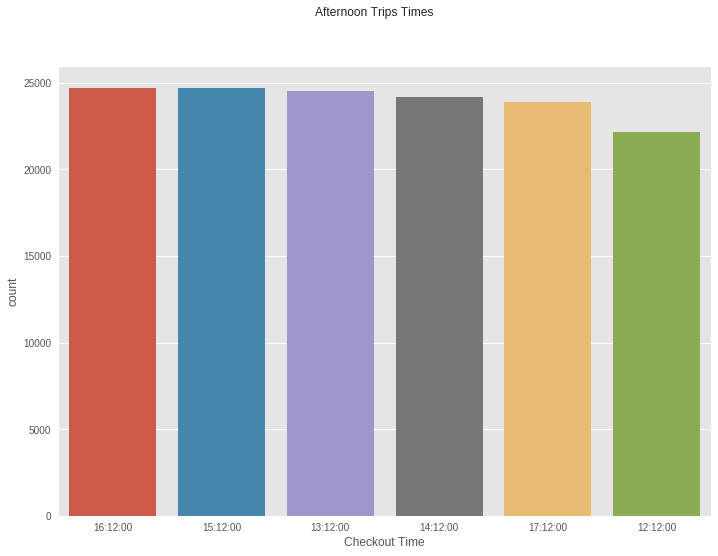

In [0]:
import seaborn as sns
sns.countplot('Checkout Time', data=Afternoon_Trips, order=pd.value_counts(Afternoon_Trips['Checkout Time']).iloc[:6].index)
plt.suptitle('Afternoon Trips Times')
plt.gcf().set_size_inches(11.7, 8.27)

# Extracting the day of the week to analyze Weekends and Weekdays behaviour

In [0]:
ebikes_days= ebikes['Checkout Date'] = pd.to_datetime(ebikes['Checkout Date'])
ebikes_days = ebikes['day_of_week'] = ebikes['Checkout Date'].dt.dayofweek

days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}

ebikes_days = ebikes['day_of_week'] = ebikes['day_of_week'].apply(lambda x: days[x])

In [0]:
ebikes_days.head()

0    Sun
1    Sun
2    Sun
3    Sun
4    Sun
Name: day_of_week, dtype: object

# Day of the week most popular for trips

In [0]:
ebikes['day_of_week'].value_counts()

Sat      209587
Sun      173681
Fri      168355
Thurs    137298
Mon      137198
Weds     127211
Tues     124599
Name: day_of_week, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


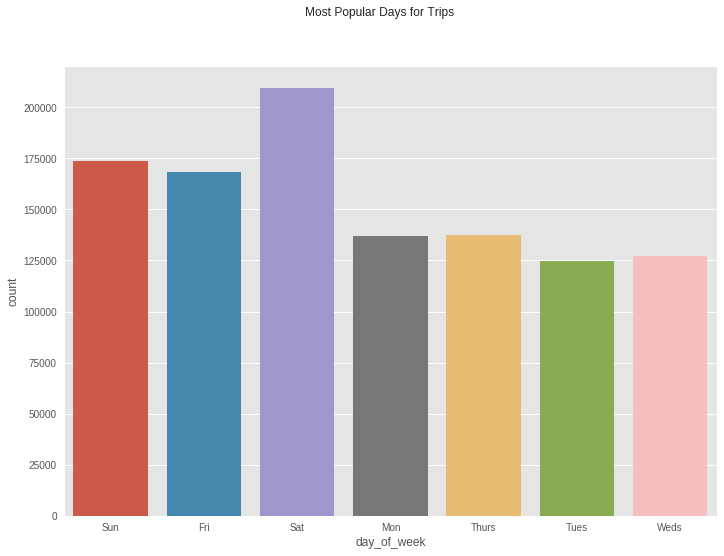

In [0]:
import seaborn as sns
sns.countplot('day_of_week',data=ebikes)
plt.suptitle('Most Popular Days for Trips')
plt.gcf().set_size_inches(11.7, 8.27)

You can see that weekends have more activity than weekdays. But, Monday has a high number. It may be because students go to the University on bycicle on Mondays.

# Most Popular Checkout Time

In [0]:
ebikes['Checkout Time'].value_counts()

16:12:00    24716
15:12:00    24714
13:12:00    24503
14:12:00    24156
17:12:00    23864
12:12:00    22183
18:12:00    21185
11:12:00    17632
19:12:00    17498
10:12:00    13361
20:12:00    12870
21:12:00    10266
9:12:00     10254
8:12:00      7942
22:12:00     7655
23:12:00     5236
0:12:00      3920
7:12:00      3617
1:12:00      2650
2:12:00      2614
6:12:00      1161
3:12:00       566
5:12:00       321
4:12:00       253
16:12:30      149
12:12:04      148
12:12:53      148
15:12:38      147
15:12:17      147
16:12:39      146
            ...  
5:36:17         1
2:41:42         1
2:43:22         1
0:30:44         1
23:40:06        1
22:37:17        1
5:02:27         1
5:48:14         1
0:40:33         1
2:54:31         1
6:31:33         1
5:28:27         1
23:24:20        1
4:50:05         1
4:47:36         1
7:31:22         1
2:34:37         1
2:54:16         1
1:38:27         1
4:59:33         1
1:30:50         1
0:17:48         1
2:22:29         1
5:13:58         1
1:20:16   

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


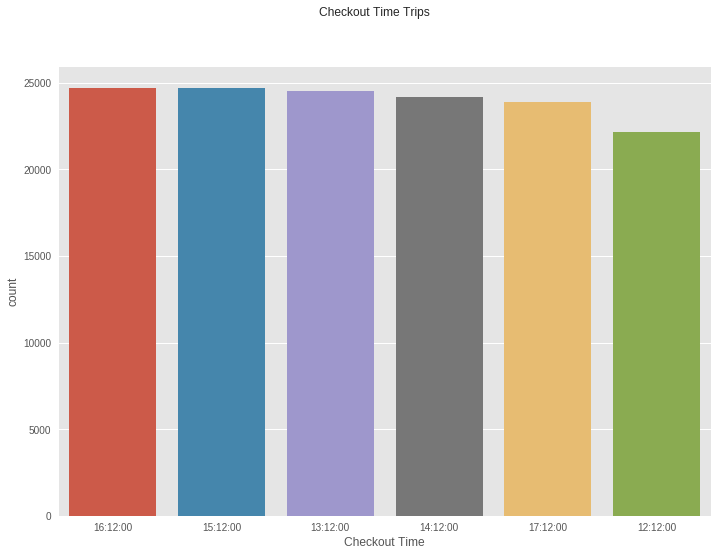

In [0]:
import seaborn as sns
sns.countplot('Checkout Time', data=ebikes, order=pd.value_counts(ebikes['Checkout Time']).iloc[:6].index)
plt.suptitle('Checkout Time Trips')
plt.gcf().set_size_inches(11.7, 8.27)

I'm trying to undertsand why the most popular trip times have '12 Minutes at the end. It can be the same type of member and it takes them 10 or 12 Minutes to arrive there and rent the bike. I don't find another reason.

# Analyzing Trips on Saturday

In [0]:
Saturday_Trips= ebikes[ebikes['day_of_week'].notnull() & (ebikes['day_of_week'] =="Sat")]

In [0]:
Saturday_Trips.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year,day_of_week
273,14702566,Walk Up,203.0,2017-05-06,12:34:28,3619.0,6th & Congress,2574.0,Zilker Park,21,5.0,2017.0,Sat
1092,13569961,Walk Up,938.0,2017-01-28,16:50:06,2574.0,Zilker Park,2574.0,Zilker Park,39,1.0,2017.0,Sat
1153,14869148,Walk Up,270.0,2017-05-20,19:02:04,2572.0,Barton Springs Pool,2574.0,Zilker Park,47,5.0,2017.0,Sat
2125,14705936,Walk Up,40.0,2017-05-06,15:34:17,2572.0,Barton Springs Pool,2574.0,Zilker Park,26,5.0,2017.0,Sat
4606,9900290537,Weekender,660.0,2015-10-03,12:12:37,2494.0,2nd & Congress,2711.0,Barton Springs @ Kinney Ave,38,10.0,2015.0,Sat


In [0]:
Saturday_Trips['Checkout Kiosk'].value_counts()

Riverside @ S. Lamar                                    9052
Davis at Rainey Street                                  7877
21st & Speedway @PCL                                    7109
Rainey St @ Cummings                                    7104
2nd & Congress                                          7066
City Hall / Lavaca & 2nd                                7018
Capitol Station / Congress & 11th                       6532
5th & Bowie                                             5617
Pfluger Bridge @ W 2nd Street                           5520
4th & Congress                                          5262
Convention Center / 4th St. @ MetroRail                 5251
Zilker Park                                             5201
Long Center @ South 1st & Riverside                     4958
Barton Springs @ Kinney Ave                             4882
South Congress & James                                  4859
South Congress & Academy                                4455
Barton Springs & Riversi

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


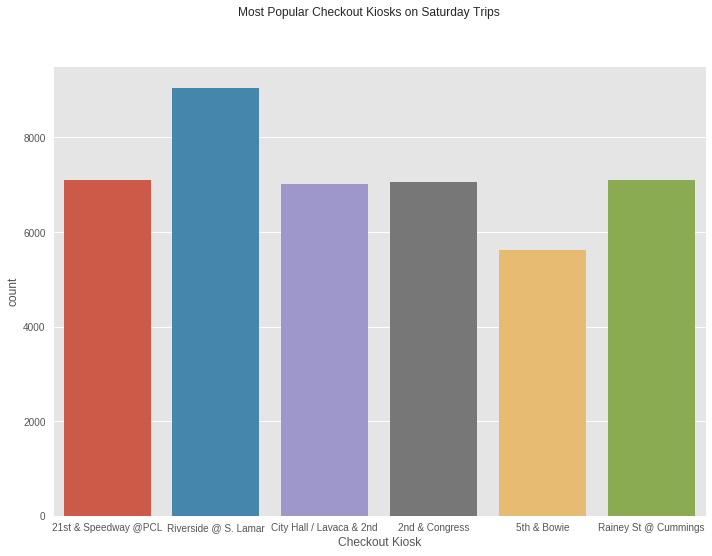

In [0]:
import seaborn as sns
sns.countplot('Checkout Kiosk', data=Saturday_Trips, order=pd.value_counts(ebikes['Checkout Kiosk']).iloc[:6].index)
plt.suptitle('Most Popular Checkout Kiosks on Saturday Trips')
plt.gcf().set_size_inches(11.7, 8.27)

# Analyzing Trips on Monday

In [0]:
Monday_Trips= ebikes[ebikes['day_of_week'].notnull() & (ebikes['day_of_week'] =="Mon")]

In [0]:
Monday_Trips.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year,day_of_week
401,9900286251,7-Day Membership (Austin B-cycle),970.0,2014-10-27,0:12:00,2495.0,4th & Congress,2707.0,Rainey St @ Cummings,7,10.0,2014.0,Mon
402,9900286252,24-Hour Kiosk (Austin B-cycle),861.0,2014-10-27,5:12:00,2711.0,Barton Springs @ Kinney Ave,2544.0,East 6th & Pedernales St.,22,10.0,2014.0,Mon
403,9900286253,Annual Membership (Austin B-cycle),576.0,2014-10-27,6:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2550.0,Republic Square @ Guadalupe & 4th St.,5,10.0,2014.0,Mon
404,9900286254,Annual Membership (Austin B-cycle),593.0,2014-10-27,7:12:00,2822.0,East 6th at Robert Martinez,2565.0,Trinity & 6th Street,8,10.0,2014.0,Mon
405,9900286255,7-Day Membership (Austin B-cycle),621.0,2014-10-27,7:12:00,2503.0,South Congress & James,NaN,Convention Center/ 3rd & Trinity,11,10.0,2014.0,Mon


In [0]:
Monday_Trips['Checkout Kiosk'].value_counts()

21st & Speedway @PCL                       9060
5th & Bowie                                4609
Riverside @ S. Lamar                       4562
2nd & Congress                             4368
City Hall / Lavaca & 2nd                   4356
4th & Congress                             4063
Convention Center / 4th St. @ MetroRail    3962
Rainey St @ Cummings                       3926
Dean Keeton & Speedway                     3616
UT West Mall @ Guadalupe                   3421
Capitol Station / Congress & 11th          3133
Davis at Rainey Street                     3120
23rd & Rio Grande                          3087
3rd & West                                 2960
22nd & Pearl                               2947
Pfluger Bridge @ W 2nd Street              2917
Guadalupe & 21st                           2832
Dean Keeton & Whitis                       2422
Barton Springs & Riverside                 2401
8th & Congress                             2391
Palmer Auditorium                       

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


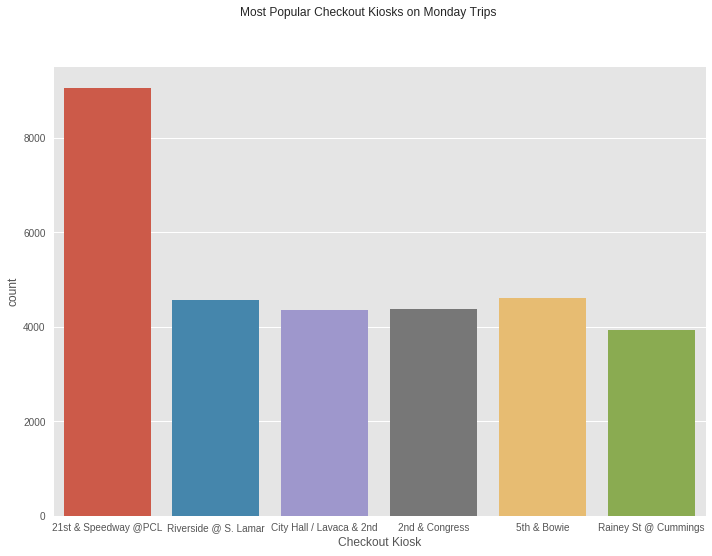

In [0]:
import seaborn as sns
sns.countplot('Checkout Kiosk', data=Monday_Trips, order=pd.value_counts(ebikes['Checkout Kiosk']).iloc[:6].index)
plt.suptitle('Most Popular Checkout Kiosks on Monday Trips')
plt.gcf().set_size_inches(11.7, 8.27)

As I thought, The most poopular kioks on Mondays is the one located at 21st & Speedway @PCL, close to the UT.

In [0]:
Monday_Trips['Checkout Time'].value_counts()

17:12:00    2905
13:12:00    2669
12:12:00    2623
16:12:00    2619
15:12:00    2519
18:12:00    2430
14:12:00    2391
11:12:00    1978
19:12:00    1957
10:12:00    1755
9:12:00     1502
20:12:00    1385
8:12:00     1340
21:12:00     975
22:12:00     751
7:12:00      591
23:12:00     429
0:12:00      409
1:12:00      214
6:12:00      186
2:12:00      132
5:12:00       41
4:12:00       34
3:12:00       30
17:12:15      28
15:12:17      27
12:12:27      25
13:12:17      25
17:12:13      25
17:12:59      25
            ... 
0:08:44        1
23:43:01       1
11:14:24       1
18:32:54       1
16:32:29       1
17:50:20       1
3:37:55        1
8:32:14        1
21:17:07       1
19:11:31       1
21:06:53       1
9:57:15        1
7:14:36        1
15:01:23       1
8:17:42        1
16:00:07       1
11:27:41       1
22:42:03       1
7:27:09        1
11:06:31       1
10:36:15       1
17:13:57       1
6:21:35        1
0:28:21        1
11:53:33       1
6:44:40        1
23:44:26       1
7:50:31       

In [0]:
Saturday_Trips['Checkout Time'].value_counts()

15:12:00    6697
14:12:00    6674
13:12:00    6389
16:12:00    6272
12:12:00    5564
17:12:00    5210
18:12:00    4394
11:12:00    4377
19:12:00    3509
10:12:00    3171
20:12:00    2621
21:12:00    2182
22:12:00    1881
9:12:00     1753
23:12:00    1355
0:12:00      926
1:12:00      753
2:12:00      752
8:12:00      715
7:12:00      253
3:12:00      183
6:12:00       82
4:12:00       59
14:12:16      46
14:12:21      42
12:12:59      41
15:12:38      41
15:12:17      40
13:12:55      39
15:12:25      37
            ... 
14:06:07       1
10:14:37       1
0:27:56        1
20:15:44       1
3:50:50        1
1:02:58        1
18:07:48       1
8:03:10        1
8:10:51        1
21:40:02       1
23:46:00       1
17:28:15       1
10:48:42       1
20:51:48       1
0:44:52        1
0:31:45        1
8:16:04        1
8:31:01        1
20:02:00       1
10:02:56       1
10:34:34       1
3:56:42        1
11:49:11       1
2:18:03        1
7:16:24        1
0:51:28        1
21:45:15       1
19:09:00      

# Most Popular Trip Duration in Minutes

In [0]:
ebikes['Trip Duration Minutes'].value_counts()

5       65354
6       63884
4       57309
7       56574
8       50209
9       44116
3       40293
10      38867
11      35422
12      31902
13      29282
14      27333
15      25004
16      23295
17      21300
2       20619
0       20235
18      19872
1       19545
19      18611
20      17703
21      16566
22      15384
23      14444
24      13559
25      12859
26      12090
27      11240
29      10813
28      10538
        ...  
1203        1
1463        1
2722        1
1457        1
4969        1
1207        1
874         1
872         1
1210        1
1453        1
1452        1
4286        1
1893        1
1214        1
1220        1
2238        1
868         1
3262        1
1215        1
2915        1
2241        1
2240        1
1451        1
1217        1
1450        1
1449        1
2912        1
1219        1
2913        1
1596        1
Name: Trip Duration Minutes, Length: 1646, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


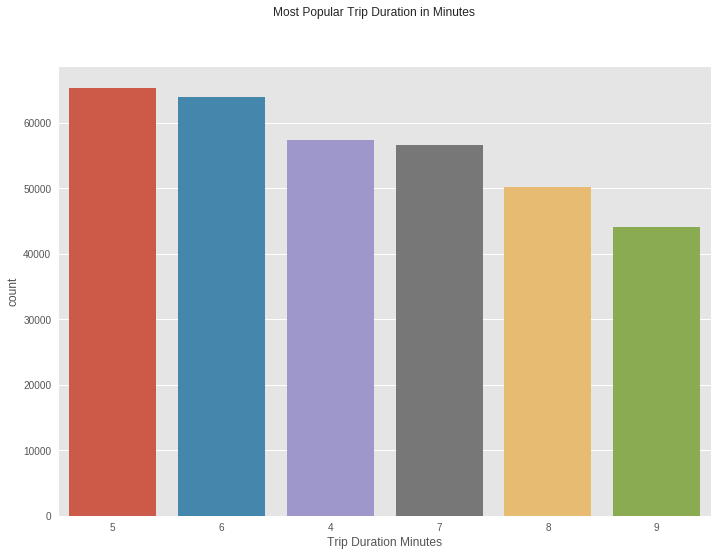

In [0]:
import seaborn as sns
sns.countplot('Trip Duration Minutes', data=ebikes, order=pd.value_counts(ebikes['Trip Duration Minutes']).iloc[:6].index)
plt.suptitle('Most Popular Trip Duration in Minutes')
plt.gcf().set_size_inches(11.7, 8.27)


The most popular trip duration in minutes are 5, 6, 4, 7, 8 and 9. I'm thinking that people may rent the bike to go and get lunch somewhere and that's the duration. Small trips from students or people at work.

In [0]:
independence_day= ebikes[ebikes['Checkout Date'] == '02/14/2018']

In [0]:
independence_day['Return Kiosk'].value_counts()

21st & Speedway @PCL                                                151
Dean Keeton & Speedway                                               80
22nd & Pearl                                                         65
Nueces & 26th                                                        55
Dean Keeton & Whitis                                                 51
Rio Grande & 28th                                                    49
Guadalupe & 21st                                                     42
23rd & Rio Grande                                                    40
21st & University                                                    40
UT West Mall @ Guadalupe                                             39
23rd & San Jacinto @ DKR Stadium                                     30
5th & Bowie                                                          23
Pfluger Bridge @ W 2nd Street                                        20
2nd & Congress                                                  

In [0]:
acl_2018= ebikes[ebikes['Checkout Date'] == '10/07/2018']

In [0]:
acl_2018['Return Kiosk'].value_counts()

21st & Speedway @PCL                                                188
Sterzing at Barton Springs                                          140
Dean Keeton & Whitis                                                 60
Guadalupe & 21st                                                     55
Barton Springs @ Kinney Ave                                          40
Dean Keeton & Speedway                                               38
23rd & Rio Grande                                                    38
22nd & Pearl                                                         36
Rio Grande & 28th                                                    33
Nueces & 26th                                                        30
Davis at Rainey Street                                               29
21st & University                                                    27
UT West Mall @ Guadalupe                                             27
City Hall / Lavaca & 2nd                                        

In [0]:
austin_events = pd.read_csv('Austin_Park_Ranger_Events_Calendar.csv')
austin_events.head(8)

,Date,Event or Activity,Location Name,Time of Event,Additional Program Information
0,08/16/2018,Wild Ones Preschool Rangers,Ranger Station in Zilker Park,10:00am - 11:00pm,https://www.facebook.com/events/214004132710234/
1,08/17/2018,Ranger Station Cottage Open,Ranger Station in Zilker Park,1:00pm - 5:00pm,NaN
2,08/18/2018,Coffee with a Ranger,Ranger Station in Zilker Park,9:00am - 11:00am,https://www.facebook.com/events/1880979915548951/
3,08/18/2018,Observational Art,Ranger Station in Zilker Park,10:00am - 11:00pm,https://www.facebook.com/events/2058080251113096/
4,08/18/2018,Ranger Station Cottage Open,Ranger Station in Zilker Park,1:00pm - 5:00pm,NaN
5,08/18/2018,Clear the Shelters,Austin Animal Center,9:00am - 6:00pm,https://www.facebook.com/events/540977339691946/
6,08/19/2018,Ranger Station Cottage Open,Ranger Station in Zilker Park,1:00pm - 5:00pm,NaN
7,08/23/2018,Wild Ones Preschool Rangers,Ranger Station in Zilker Park,10:00am - 11:00pm,https://www.facebook.com/events/214004132710234/


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


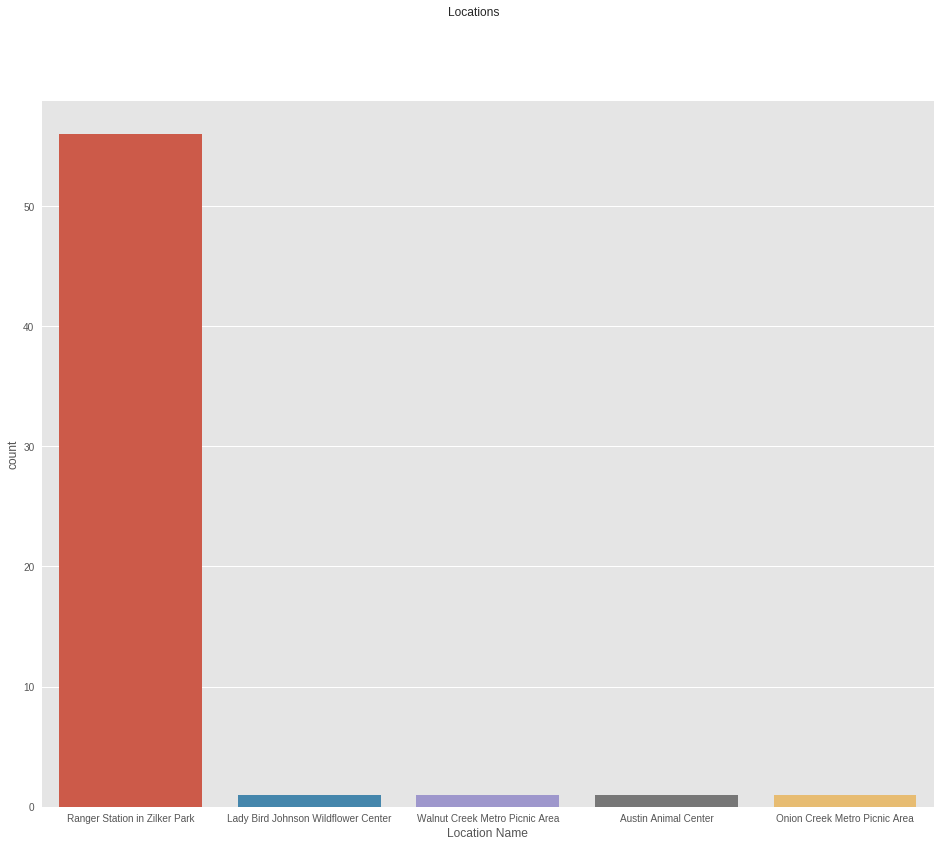

In [0]:
import seaborn as sns
sns.countplot('Location Name', data=austin_events, order=pd.value_counts(austin_events['Location Name']).iloc[:6].index)
plt.suptitle('Locations')
plt.gcf().set_size_inches(16, 13)